# Spin-Label Enemble Refinement with DEER data using BioEn

By applying this ipython notebook, you can perform spin-label ensemble refinement with DEER data using BioEn (as done in Reichel et al. JPC Letters (2018)). The steps of the ipython notebook are <br> 
1. Preparation of the input <br> 
2. BioEn <br> 
3. Analysis of the BioEn results<br> 

(as shown in Reichel et al. PLoS Computational Biology (2018)). You can either use the provided test data or define your own protein of interest, use your own rotamer library, and define labeled position of interest. The part, which can be individualized by the user, is highlighted in green. 


### Theory and methods applied in this ipython notebook are available in:
G. Hummer, J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting,” J. Chem. Phys. 143, 243150 (2015). <br>
K. Reichel, J. Koefinger, L. S. Stelzl, G. Hummer, “Precision DEER distances from Spin-Label Ensemble Refinement,” J. Phys. Chem. Letters (2018).


In [1]:
import numpy as np
import pickle
import pandas as pd

import MDAnalysis as mda
import MDAnalysis.analysis.align
import MDAnalysis.lib.NeighborSearch as KDNS
import MDAnalysis.analysis.distances

from scipy.special import fresnel

import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import bioen_rotamer as br

%matplotlib inline

# 1. Preparation

## Settings and input parameters for preparation

In [2]:
# use the protein of interest
structure = "files/structure/3MC8_xray.pdb"

# pdb of the label, trajectory and weights of the rotamer library
rotamer_library_pdb = "files/rotamer_library/rotamer1_R1A_298K_2015.pdb"
rotamer_library_dcd = "files/rotamer_library/rotamer1_R1A_298K_2015.dcd"
rotamer_library_weights = "files/rotamer_library/rotamer1_R1A_298K_weights_2015.dat"

# define time steps from experimental measurement [ns]
experimental_data_time_steps = np.loadtxt("files/experimental_data/exp-370-292-signal-deer.dat")[:,0]*1000

# define single spin label positions
spin_labels = [[370, 'A'], [292, 'C']]

# define spin_label_pairs used for the spin-label reweighting and include the time steps from the experiments
spin_label_pairs = [[[370, 'A'], [292, 'C'], experimental_data_time_steps]]

# define path of the output of the preparation
path_output_preparation = "files/output_preparation"

# define clash_distance between atoms of the spin-spin label and the protein
clash_distance = 1.4

## Obtain for each labeled position a trajectory of spin-label rotamers

In [5]:
def get_rotamers():
    xray = mda.Universe(structure)
    rotamers = mda.Universe(rotamer_library_pdb, rotamer_library_dcd)

    rotamer_labels = dict()
    for label in spin_labels:
        resid = label[0]
        chainid = label[1]
        dcd_fn = '{}/tmp_traj_{}_{}.dcd'.format(path_output_preparation, resid, chainid)
        d = dict()
        br.fit_rotamers(rotamers, xray, resid, chainid, dcd_fn)
        rotamer_site = mda.Universe(rotamers.filename, dcd_fn)
        rotamer_clash = br.find_clashing_rotamers(clash_distance, rotamer_site, xray, resid, chainid)
        d['site'] = rotamer_site
        d['clash'] = rotamer_clash

        rotamer_nitrogen = rotamer_site.select_atoms("name N1")
        rotamer_oxygen = rotamer_site.select_atoms("name O1")
        rotamer_positions = dict()
        for rotamer in rotamer_site.trajectory:
             if not rotamer_clash[rotamer.frame]:
                rotamer_electron = (np.array(rotamer_nitrogen.positions[0][0:3]) + np.asarray(rotamer_oxygen.positions[0][0:3]))/2.0
                rotamer_positions[rotamer.frame] = [rotamer_electron]
        d['positions'] = rotamer_positions
        ln = '{}-{}'.format(resid, chainid)
        rotamer_labels[ln] = d
    return rotamer_labels

In [6]:
rotamer_labels = get_rotamers()

Step   216/216 [100.0%]
Step   216/216 [100.0%]


## Get for each spin-label distance in the rotamer trajectories a single DEER trace

Get for each distance, which is measured between the unpaired electrons of the spin-labels rotamer states, a single DEER trace.

In [7]:
def get_preparation_output(rotamer_labels, rotamer_library_weights, path_output_preparation):
    for slp in spin_label_pairs:
        br.get_deer_from_single_pair(slp, rotamer_labels, rotamer_library_weights, path_output_preparation)    
    return

In [8]:
get_preparation_output(rotamer_labels, rotamer_library_weights, path_output_preparation)

Generated files are saved in files/output_preparation:
	data_370-A_292-C.pkl --> contains all calculated DEER traces based on spin-label distances
	models_370-A_292-C.dat --> list of the model ids
	weights_370-A_292-C.dat --> prior weights (normalized) derived from input weights of single rotamer states
	frames_370-A_292-C.pkl --> spin-label rotamers and spin-label distances for each ensemble member
Number of rotamer combinations (number of ensemble members): 5940


# BioEn

## Settings and input parameters for BioEn

In [9]:
# define theta series, bioen performs for each theta reweighting
theta_series = [10e5, 10e4, 10e3, 10e2, 10e1, 10e0, 10e-1, 0]
np.savetxt('theta.dat', np.array(theta_series))

# number of rotamers 
number_of_ensemble_members = '5940'

# reweighting is done for a single spin-label pair
label_pair = '370-292'

# define path for the output of BioEn
path_output_bioen = "files/output_bioen"

In [10]:
def run_bioen_script(slp):
    spin_label_pair = '{}-{}'.format(slp[0][0], slp[1][0])
    file_id = '{}-{}_{}-{}'.format(slp[0][0], slp[0][1], slp[1][0], slp[1][1])
    ! bash run_bioen_ipynb_deer.sh $path_output_bioen $number_of_ensemble_members $spin_label_pair $file_id
    return

In [ ]:
#%%capture c
for slp in spin_label_pairs:
    run_bioen_script(slp)

INFO:root:BioEn weight refinement starts with
INFO:root:    optimization method: log-weights
INFO:root:    optimization algorithm: bfgs
INFO:root:    optimization minimizer: scipy


# Analysis

## Settings and input parameters for analysis of BioEn outputs

In [13]:
# output of BioEn is a pkl file (contains all the necessary information)
bioen_pkl = "test-5940-370-A_292-C.pkl"
df = pd.read_pickle("{}/{}".format(path_output_bioen, bioen_pkl))
bioen_data = df.to_dict()

`bioen_data` contains all needed and useful information to analyse the BioEn calculations. <br>
For each previously defined confidence value $\theta$ (defined in the variable `theta_series`) a list of variables are available:

**Experimental information**
- **`exp`** <br> 
--> experimental DEER signals for each label <br>
--> in case of DEER data, this variable contains time, DEER signal and polynomial fit of the DEER signal <br>
--> time: `data['exp']['370-292'][:,0]` <br>
--> DEER trace: `data['exp']['370-292'][:,1]` <br>
--> polynomial fit of DEER trace: `data['exp']['370-292'][:,1]` <br>
- **`exp_err`** <br>
--> error/noise of each experimental data point defined in `exp`
- **`labels`** <br> 
--> list of labels used in the refinement
- **`nrestraints`** <br>
--> number of data points ($M$)

**Simulated data and parameters**
- **`sim_init`** <br> 
--> initial ensemble averaged simulated DEER traces for each label (see above for exp)
- **`sim_wopt`** <br>
--> optimized ensemble averaged simulated DEER traces for each label and for a given confidence value $\theta$
- **`moddepth`** <br>
--> modulation depth of the optimized ensemble averaged simulated DEER traces for each label 
- **`nmodels_list`** <br>
--> list of model ids (extracted e.g. from models_370-292.dat)
- **`nmodels`** <br>
--> number of models ($N$), which is also the number of ensemble members (relevant in the BioEn context) <br>
--> `nmodels` = `nrotamers` <br>
--> number of rotamers, which is needed to backcalculate weights of rotamers of a spin-label position (relevant in the analysis contex) <br>

**Free energy parameters**
- **`theta`** <br>
--> confidence parameter $\theta$
- **`chi2_init`** <br>
--> deviation from the experimental data with the initial weight distribution <br>
--> if you use `chi2_init` of the maximal value of $\theta$, $\chi^2$ is calculated with the prior weight distribution `w0`
- **`chi2`** <br>
--> optimal $\chi^2$ calculated with optimal weight distribution `wopt`
- **`S_init`** <br>
--> initial relative entropy
--> if you use `S_init` of the maximal value of $\theta$, $S$ is equal to $0$
- **`S`** <br>
--> relative entropy of optimized weight distribution
- **`w0`** <br>
--> reference weight distribution
- **`winit`** <br>
--> initial weight distribution
- **`wopt`** <br>
--> optimal weight distribution <br>
--> optimized for each $\theta$

**Misc**
- **`len_sim`** <br>
--> seconds it took for BioEn to optimize for a given value of $\theta$
- **`optimization_method`** <br>
--> information about the optimization method: log-weights or forces
- **`optimization_minimizer`** <br>
--> information about the minimer: scipy, GSL, LBFGS
- **`optimization_algorithm`** <br>
--> information about the inimizer: <br>
--> scipy: bfgs, lbfgs, cg <br>
--> GSL: conjugate_fr, conjugate_pr, bfgs, bfgs, steepest_descent<br>
--> LBFGS: lbfgs <br>


Several default plots are provided in the following, so that the analysis is as intuitive as the preparation and running BioEn itself.


In [17]:
# define path for the output of the analysis
path_output_analysis = 'files/output_analysis'

# load frames pkl file, which was generated in the preparation step (see above)
# frames_dict is needed to get the weights of spin-label rotamers of a single labeled position
frames_pkl = '{}/frames_370-A_292-C.pkl'.format(path_output_preparation)
with open(frames_pkl, 'r') as file:
    [frames_dict] = pickle.load(file)

### $\chi^{2} vs. S_{\mathrm{KL}}$

the lower $\theta$, the closer to experimental data

In [18]:
def visualize_chi2_skl(bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    for theta in theta_series:
        chi2 = bioen_data[theta]['chi2'] / bioen_data[theta]['nrestraints']
        skl = - bioen_data[theta]['S']
        ax.scatter(skl, chi2, marker='^', s=160, label=theta)  
    
    ax.set_xticks(range(-1,6,1))   
    ax.set_xticklabels(range(-1,6,1), fontsize=fs)
    ax.set_xlim(-0.4,5.5)
    ax.set_xlabel(r'$S_{\mathrm{KL}}$', fontsize=fs)

    ax.set_yticks(np.arange(0,10,1))   
    ax.set_yticklabels(np.arange(0,10,1), fontsize=fs)
    ax.set_ylim(-0.2, 4)
    ax.set_ylabel(r'$\chi^{2}$', fontsize=fs)    
    
    plt.grid()
    
    ax.legend(ncol=2, fontsize=10)
    
    plt.tight_layout()
    plt.savefig("{}/bioen_chi2_skl_370-A_292-C.png".format(path_output_analysis), dpi=400)
    plt.show()
    return

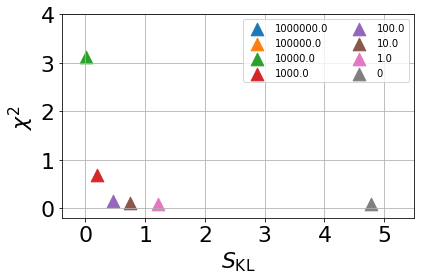

In [19]:
visualize_chi2_skl(bioen_data)

## Comparison experimental and weighted ensemble averaged DEER traces

In [20]:
def visualize_deer_traces(theta, bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    theta_max = np.max(bioen_data.keys())
    
    label = bioen_data[theta]['exp']['deer'].keys()[0]
    exp = bioen_data[theta]['exp']['deer'][label]
    exp_err = bioen_data[theta]['exp_err']['deer'][label]
    
    sim_init = bioen_data[theta_max]['sim_init']['deer'][label]
    sim = bioen_data[theta]['sim_wopt']['deer'][label]
    
    ax.plot(exp[:,0], exp[:,1], color='black', linewidth=2.5, label='Exp.',zorder=2)
    ax.fill_between(exp[:,0], exp[:,2]-exp_err, exp[:,2]+exp_err, color='black', alpha=0.2, label='Error', linewidth=1.0, zorder=1)
    ax.plot(exp[:,0], sim_init, color='green', linewidth=3.0, label=r"X-ray",zorder=0)
    ax.plot(exp[:,0], sim, color='red', linewidth=3.0, label=r"BioEn".format(theta),zorder=3)
    
    ax.set_xticks(np.arange(0,4.0,1.0))
    ax.set_xticklabels(np.arange(0,4.0,1.0), fontsize=fs)
    ax.set_xlim(0,3.5)
    ax.set_xlabel(r't [$\mu$s]', fontsize=fs+2)

    ax.set_yticks(np.arange(-0.6,1.4,0.2))
    ax.set_yticklabels(np.arange(-0.6,1.4,0.2), fontsize=fs)
    ax.set_ylim(0.35,1.0)
    ax.set_ylabel(r'F(t)', fontsize=fs)

    ax.legend(loc=1, ncol=2, fontsize=10)
    
    plt.grid()
    
    plt.tight_layout()
    plt.savefig("{}/bioen_deer_370-A_292-C.png".format(path_output_analysis), dpi=400)
    plt.show()
    return

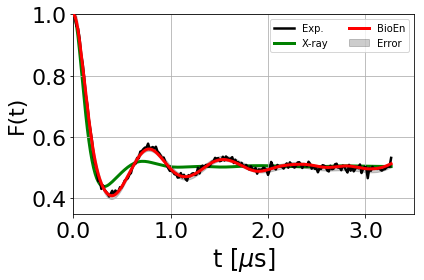

In [21]:
theta = 1.0
visualize_deer_traces(theta, bioen_data)

In [22]:
def visualize_deer_traces_all_thetas(bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    theta_max = np.max(bioen_data.keys())
    
    label = bioen_data[theta_max]['exp']['deer'].keys()[0]
    exp = bioen_data[theta_max]['exp']['deer'][label]
    ax.plot(exp[:,0], exp[:,1], color='black', linewidth=2.5, label='Exp.',zorder=2)
    
    a = np.linspace(0.1, 0.7, num=len(theta_series))
    for i, theta in enumerate(theta_series):
        sim = bioen_data[theta]['sim_wopt']['deer'][label]
        ax.plot(exp[:,0], sim, color='red', alpha=a[i], linewidth=3.0, label=r"BioEn ($\theta={}$)".format(theta), zorder=3)
    
    ax.set_xticks(np.arange(0,4.0,1.0))
    ax.set_xticklabels(np.arange(0,4.0,1.0), fontsize=fs)
    ax.set_xlim(0,3.5)
    ax.set_xlabel(r't [$\mu$s]', fontsize=fs+2)

    ax.set_yticks(np.arange(-0.6,1.4,0.2))
    ax.set_yticklabels(np.arange(-0.6,1.4,0.2), fontsize=fs)
    ax.set_ylim(0.35,1.0)
    ax.set_ylabel(r'F(t)', fontsize=fs)

    ax.legend(loc=1, ncol=2, fontsize=10)
    
    plt.grid()
    
    plt.tight_layout()
    plt.savefig("{}/bioen_theta_series_370-A_292-C.png".format(path_output_analysis), dpi=400)
    plt.show()
    return

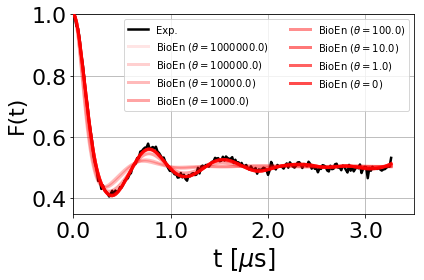

In [23]:
visualize_deer_traces_all_thetas(bioen_data)

## Cummulative weight

In [24]:
def visualize_cum_dist(theta, bioen_data):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    nmodels = bioen_data[theta]["nmodels"]
    a = np.vstack((bioen_data[theta]["nmodels_list"], np.array(bioen_data[theta]["wopt"]).reshape(1,-1)))
    
    models = []
    for i, id in enumerate(np.argsort(a[1,:])[::-1]):
        if i == 0: models.append([a[:,id][0], float(a[:,id][1]), float(a[:,id][1])])
        else: models.append([a[:,id][0], float(a[:,id][1]), models[-1][2]+float(a[:,id][1])])

    models = np.array(models)
    ax.scatter(range(1,nmodels+1), models[:,2], s=20, color='green', zorder=2)
    ax.plot(range(1,nmodels+1), models[:,2], color='black', zorder=1)

    ax.set_xticks([0.0, 10.0, 100.0, 1000.0, 10000.0])
    ax.set_xticklabels([r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize=fs)
    ax.set_xlabel("Fraction of configurations", fontsize=fs)
    ax.semilogx()
    ax.set_yticklabels(np.arange(0,1.2,0.2), fontsize=fs)
    ax.set_ylim(0,1)
    ax.set_ylabel("Cumulative distribution", fontsize=fs)
    
    ax.grid()
    
    plt.savefig('{}/bioen_cum_weights.png'.format(path_output_analysis), dpi=600, bbox_inches='tight')
    return

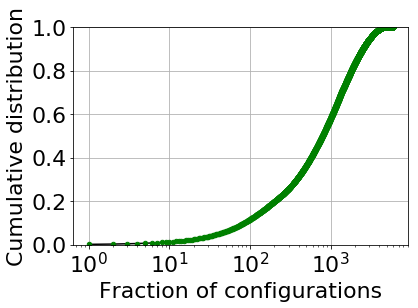

In [25]:
theta = 10.0
visualize_cum_dist(theta, bioen_data)

## Distance distribution

### Obtain distances based on the weights from the BioEn calculation and frames*pkl

In [26]:
def get_distances(bioen_data, theta):
    nmodels = bioen_data[theta]["nmodels"]
    weights = np.array(bioen_data[theta]["wopt"])
    nmodels_weights = (np.vstack((bioen_data[theta]["nmodels_list"], 
                       np.array(bioen_data[theta]["wopt"]).reshape(1,-1)))).T
    weights_distances = []
    for model in nmodels_weights:
        weights_distances.append([frames_dict[model[0]]['dist'], model[1]])
    return np.array(weights_distances)

In [27]:
# define the most reliable confidence value
theta = 1000.0

weights_distances_all = dict()
for spin_label_pair in spin_label_pairs:
    lp_name = '{}-{}'.format(spin_label_pair[0], spin_label_pair[1])
    weights_distances_all[lp_name] = get_distances(bioen_data, theta)

### Visulize distances with prior and optimized weights

In [28]:
def visualize_dist_distr(weights_distances):
    fs = 22
    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot(111)
    
    distances = weights_distances[:,0]
    weights = weights_distances[:,1]
    
    ax.axes.hist(distances, bins=100, color='green', label="X-ray (w0)", alpha=0.2, zorder=2, normed=True)
    ax.axes.hist(distances, bins=100, color='green', alpha=0.8, zorder=2, normed=True, histtype='step')
    ax.axes.hist(distances, weights=weights, bins=100, color='red', label=r"Shift (wopt, $\theta=10^3$)", alpha=0.2, normed=True,)
    ax.axes.hist(distances, weights=weights, bins=100, color='red', alpha=0.8, normed=True, histtype='step')
    
    ax.set_xticks(range(0,80,10))
    ax.set_xticklabels(range(0,80,10), fontsize=fs)
    ax.set_xlim(15, 60)
    ax.set_xlabel(r'r [nm]', fontsize=fs)

    ax.set_yticklabels([], fontsize=fs)
    ax.set_ylabel(r'P(r)', fontsize=fs)    
    
    plt.grid(zorder=3)
    
    plt.savefig('{}/bioen_dist_distr_370-A_292-C.png'.format(path_output_analysis), dpi=600, bbox_inches='tight')
    
    return

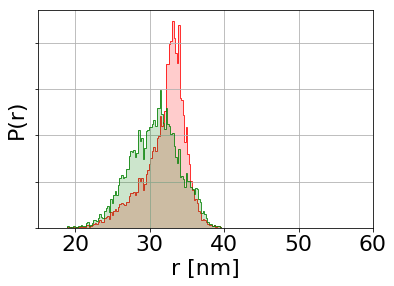

In [29]:
for spin_label_pair in spin_label_pairs:
    lp_name = '{}-{}'.format(spin_label_pair[0], spin_label_pair[1])
    visualize_dist_distr(weights_distances_all[lp_name])

## Rotamer distribution of spin-label positions

### Calculate rotamer distribution

In [39]:
rotamer_weights_all = dict()
for slp in spin_label_pairs:
    slp_id = '{}-{}-{}-{}'.format(slp[0][0], slp[0][1], slp[1][0], slp[1][1])
    rotamer_weights = dict()
    for label in slp[0:2]:
        label_id = '{}-{}'.format(label[0], label[1])
        rotamer_weights[label_id] = br.get_weighted_rotamer_states(frames_dict, bioen_data, label[0], theta=1000.0)
    rotamer_weights_all[slp_id] = rotamer_weights

### Write pdbs 
- with the rotamer states (position of the unpaired electron between the nitroxidide N and O)
- the cummulative weight of that rotamer states as the B-factor

In [44]:
def write_rotamer_pdb(slp_id, label_id):
    rotamer_positions = rotamer_labels[label_id]["positions"]
    rotamer_pdb = "{}/weighted_rotamers_{}_{}.pdb".format(path_output_analysis, slp_id, label_id)
    pdb = open(rotamer_pdb, 'w')

    w_check = []
    for frame, weights in rotamer_weights_all[slp_id][label_id].iteritems():
        w_check.append(np.sum(weights))
        x = rotamer_positions[frame][0][0]
        y = rotamer_positions[frame][0][1]
        z = rotamer_positions[frame][0][2]
        line =  "ATOM   {:4d}  O   ALA A{:4d}    {:8.3f}{:8.3f}{:8.3f}     {:6.8f}     \n".format(int(frame), 
                                                                                                  int(frame), 
                                                                                                  x, y, z, 
                                                                                                  np.sum(weights))
        pdb.write(line)
    pdb.close()
    
    print 'Find the pdb in \"{}\".'.format(path_output_analysis)
    return

In [45]:
for slp in spin_label_pairs:
    slp_id = '{}-{}-{}-{}'.format(slp[0][0], slp[0][1], slp[1][0], slp[1][1])
    for label in slp[0:2]:
        label_id = '{}-{}'.format(label[0], label[1])
        write_rotamer_pdb(slp_id, label_id)

Find the pdb in "files/output_analysis".
Find the pdb in "files/output_analysis".
